# Eval of Paper : ...
https://parts-of-speech.info

### Read in Files
This function takes in a path to a directory (all_classes, beschreibung_txt, filter_1, all_nouns) and returns:

1) name of the example
2) example text
3) ground truth labels
4) texts after filter 1 (according to [compare] paper)
5) all nouns (all candidates for classes)

In [1]:
import os


In [2]:
#examples_dir = "/Users/vasiliyseibert/Library/Mobile Documents/com~apple~CloudDocs/Work/RESEARCH/requirements_extraction/DATA/eng/"
examples_dir = "/Users/vs21/Library/Mobile Documents/com~apple~CloudDocs/Work/RESEARCH/requirements_extraction/DATA/eng/"

def get_examples(examples_dir, test=True, test_folder="RentAConsult"):
    #returns a list of 1) name of the example, 2) example text and 3) labels (ground truth) and 4) example text after filter
    example_names = os.listdir(examples_dir)
    examples = []
    for name in example_names:
        # remove this after Pipeline complete
        if name != test_folder and test == True:
            continue
        with open(examples_dir + "/" + name + "/beschreibung_txt", 'r') as file:
            example_text = file.readlines() # return example text
        with open(examples_dir + "/" + name + "/all_classes.txt", 'r') as file:
            example_labels = file.readlines() # return ground truth labels
            example_labels = example_labels[0].strip()
            example_labels = example_labels.split(",")
        with open(examples_dir + "/" + name + "/filter_1.txt", 'r') as file:
            example_sentence_filter = file.readlines() # return text after filer 1 (siehe paper)
            example_sentence_filter = [sentence.replace("\n", "") for sentence in example_sentence_filter]
            example_sentence_filter = " ".join(example_sentence_filter)
        examples.append([name, example_text[0], example_labels, example_sentence_filter])
            
    return examples
    
            
        

In [3]:
examples = get_examples(examples_dir)
examples[0]

['RentAConsult',
 'The service company "Rent a Consult" is planning to rethink its HR System. Up until now, every rentable consultant was documented in Word Documents. These Documents contained the Name of the consultant, available locations and qualifications in plain text. On the next system, a potential customer must be able to search and access all available consultants for his order through a website. The user must be able to filter the consultants by the criteria of his choice, like qualifications. The user must be able to create a user account. If a user decides to create a user account, he must enter an IBAN.',
 ['user', 'account', 'consultant', 'order', 'qualification', 'website'],
 'Service company "Rent a Consult" is planning to rethink its HR System. Rent a Consult is a service company. Consultant was documented in Word Documents. Documents contained the Name of the consultant. Documents contained the locations of the consultant. Documents contained the qualifications of th

### stanford core nlp
method receives a sentence and returns : Normal Text, lemmatized text, POS.

In [2]:
import stanza
stanza.download('en')       # This downloads the English models for the neural pipeline
nlp = stanza.Pipeline('en', processors='tokenize,pos,lemma,depparse') # This sets up a default neural pipeline in English


2023-05-26 13:06:32 INFO: Downloading default packages for language: en (English) ...
2023-05-26 13:06:33 INFO: File exists: /Users/vs21/stanza_resources/en/default.zip
2023-05-26 13:06:36 INFO: Finished downloading models and saved to /Users/vs21/stanza_resources.
2023-05-26 13:06:36 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-05-26 13:06:37 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2023-05-26 13:06:37 INFO: Use device: cpu
2023-05-26 13:06:37 INFO: Loading: tokenize
2023-05-26 13:06:37 INFO: Loading: pos
2023-05-26 13:06:37 INFO: Loading: lemma
2023-05-26 13:06:37 INFO: Loading: depparse
2023-05-26 13:06:37 INFO: Done loading processors!


In [3]:
test_sentence = "Documents contained the Name of the consultant."
def core_nlp(sentence):
    # method receives a sentence and returns : Normal Text, lemmatized text, POS.
    result_list = []
    doc = nlp(sentence)
    for sentence in doc.sentences:
        for word in sentence.words:
            result_list.append([word.text, word.lemma, word.pos, word.deprel, word.head])
            # deprel doku : https://stanfordnlp.github.io/stanza/depparse.html
    return result_list


In [4]:
nlp_results = core_nlp(test_sentence)
nlp_results

[['Documents', 'document', 'NOUN', 'root', 0],
 ['contained', 'contain', 'VERB', 'acl', 1],
 ['the', 'the', 'DET', 'det', 4],
 ['Name', 'name', 'NOUN', 'obj', 2],
 ['of', 'of', 'ADP', 'case', 7],
 ['the', 'the', 'DET', 'det', 7],
 ['consultant', 'consultant', 'NOUN', 'nmod', 4],
 ['.', '.', 'PUNCT', 'punct', 1]]

### get all nouns (potential candidates for classes)
extracted from the original text

In [5]:
def get_all_nouns(nlp_results):
    nouns = []
    for word in nlp_results:
        normal_word = word[0]
        lemma_word = word[1]
        pos_word = word[2]
        deprel_word = word[3]
        if pos_word == "NOUN":
            nouns.append(lemma_word)
    return list(set(nouns))

In [6]:
examples[0][1]

NameError: name 'examples' is not defined

In [9]:
nlp_result = core_nlp(examples[0][1])
nouns = get_all_nouns(nlp_result)
nouns

['user',
 'criterion',
 'consultant',
 'qualification',
 'order',
 'choice',
 'website',
 'document',
 'hr',
 'company',
 'account',
 'system',
 'name',
 'service',
 'text',
 'customer',
 'location']

### Rule based extraction according to [compare]
This function takes in the example texts (after Filter 1) and returns 
* extracted classes
* extracted attributes
* extracted relationships

universal dependencies link : https://universaldependencies.org/u/pos/

In [10]:
# EXAMPLE NLP RESULTS
nlp_results

[['Documents', 'document', 'NOUN', 'root', 0],
 ['contained', 'contain', 'VERB', 'acl', 1],
 ['the', 'the', 'DET', 'det', 4],
 ['Name', 'name', 'NOUN', 'obj', 2],
 ['of', 'of', 'ADP', 'case', 7],
 ['the', 'the', 'DET', 'det', 7],
 ['consultant', 'consultant', 'NOUN', 'nmod', 4],
 ['.', '.', 'PUNCT', 'punct', 1]]

In [41]:
def test_rules():
    # test sentences für die Funktion rule_based_extraction
    
    # RULE 14: If If a sentence has no verbs (VP), then discard it.
    # The sentence "Ice cream is great!" has no verbs and should be discarded
    test_input = "Ice cream is great!"
    nlp_result = core_nlp(test_input)
    rule_result = rule_based_extraction(nlp_result)
    test_result = rule_result["classes"] == [] and rule_result["methods"] == []
    print(f"Rule 14 Test passed : {test_result}")
    
    # RULE 15: If a prepositional phrase (PP), adjective phrase (ADJP), determiner (DT), or adjective (JJ) precedes the subject of the sentence, then discard that phrases.
    test_input = "the user has some feedback"
    nlp_result = core_nlp(test_input)
    rule_result = rule_based_extraction(nlp_result)
    test_result = rule_result["classes"] == [] and rule_result["methods"] == []
    print(f"Rule 15 Test passed : {test_result}")
    
    # C-Rule 1: Extract the common nouns (e.g., Person, User) <NN> tags, and proper nouns (e.g., System, Human) <NNP> tags from the text and map them to classes.
    test_input = "User operates System."
    nlp_result = core_nlp(test_input)
    rule_result = rule_based_extraction(nlp_result)
    test_result = rule_result["classes"] == ['user', 'system']
    print(f"C-Rule 1 Test passed : {test_result}")
    
    # C-Rule 2: If a sentence in (Subject–Verb–Object); Subject <nsubj> and Object <dobj> forms are mapped to candidate classes.
    test_input = "Sam goes Home."
    nlp_result = core_nlp(test_input)
    rule_result = rule_based_extraction(nlp_result)
    test_result = rule_result["classes"] == ['Sam', 'Home'] 
    print(f"C-Rule 2 Test passed : {test_result}")
    
    # C-Rule 3: If the noun is post-fixed by preposition <IN> tag, then ignore it as a class and map it as a part of a method, e.g., System records details of a candidate. “System” and “candidate” are candidate classes, and “records details” is a method of the class “system”.
    test_input = "System records details of a candidate."
    nlp_result = core_nlp(test_input)
    rule_result = rule_based_extraction(nlp_result)
    test_result = rule_result["classes"] == ['system', 'candidate'] and rule_result["methods"] == [('system', 'record detail')]
    print(f"C-Rule 3 Test passed : {test_result}")
    
    
    # C-Rule 4: Identify candidate classes from the ‘IsA’ relationship (inheritance), e.g., EU-Rent is a car rental company. EU-Rent is a subclass of Car Rental Company.
    # not implemented because conflict with rule 14.
    
    # AS-Rule 1: Extract the prepositional phrases from (<VB>+ <IN> or <To>) tags among noun phrases (two classes), such as “has”, “next to”, “part of”, “works for”, “contained in”, “talk to”, “order to”, and identify the noun phrases associated with it. These phrases are mapped to association relationships and the associated verb is used as the caption of association.
    test_input = "Sam works for the store"
    nlp_result = core_nlp(test_input)
    rule_result = rule_based_extraction(nlp_result)
    test_result = rule_result["association"] == [('Sam', 'store')]
    print(f"AS-Rule 1 Test passed : {test_result}")
    
    
    # AS-Rule 3: If a sentence is in the form (Noun+Verb+ Noun) where both nouns are candidate classes, then the verb is an association relationship. Similarly, if the sentence is in the form of (Subject-Predicate-Object), then there is an association between subject and object.
    test_input = "Car drives passenger"
    nlp_result = core_nlp(test_input)
    rule_result = rule_based_extraction(nlp_result)
    test_result = rule_result["association"] == [('car', 'passenger')] or rule_result["association"] == [('passenger', 'car')]
    print(f"AS-Rule 3 Test passed : {test_result}")
    
    # AG-Rule 1: Extract phrases such as “have”, “hold”, “possess”, “carry”, “involve”, “imply”, “embrace”, “contains”, “consists of”, “comprises of”, “is-part-of”, “included-in”, “belong-to”, “divided to”, “has part” or “is- made-up-of” between subject and object.
    test_input = "Sam carry basket"
    nlp_result = core_nlp(test_input)
    rule_result = rule_based_extraction(nlp_result)
    test_result = rule_result["aggregation"] == [('basket', 'Sam')]
    print(f"AG-Rule 1 Test passed : {test_result}")

In [42]:
test_input = "Sam carry basket"
nlp_result = core_nlp(test_input)
nlp_result

[['Sam', 'Sam', 'PROPN', 'nsubj', 2],
 ['carry', 'carry', 'VERB', 'root', 0],
 ['basket', 'basket', 'NOUN', 'obj', 2]]

In [70]:
# function you are working on ...

def rule_based_extraction(_nlp_results):
    classes = []
    methods = [] # class, method
    generalization = [] # class 1, class 2
    association = []
    aggregation = []
    
    pos_tags = [item[2] for item in _nlp_results]
    lemma_words = [item[1] for item in _nlp_results]
    linguistic_typology = [item[3] for item in _nlp_results]
    
    ### RULE 14 and 15 are for discarding sentences ###
    
    # RULE 14: If If a sentence has no verbs (VP), then discard it.
    try:
        if not any(x[2] == "VERB" for x in _nlp_results): return {"classes": classes, "methods":methods}
    except:
        pass
    RULE 15: If a prepositional phrase (PP), adjective phrase (ADJP), determiner (DT), or adjective (JJ) precedes the subject of the sentence, then discard that phrases.
    try:
        if linguistic_typology[pos_tags.index("DET") + 1] == "nsubj" : return {"classes": classes, "methods":methods}
    except:
        pass
    try:
        if linguistic_typology[pos_tags.index("ADJ") + 1] == "nsubj" : return {"classes": classes, "methods":methods}
    except:
        pass
    

        
    
    
    # C-Rule 1: Extract the common nouns (e.g., Person, User) <NN> tags, and proper nouns (e.g., System, Human) <NNP> tags from the text and map them to classes.
    try:
        [classes.append(x[1]) for x in _nlp_results if x[2] == "NOUN" and x[1] not in classes]
    except:
        pass
    try:
        [classes.append(x[1]) for x in _nlp_results if x[2] == "PROPN" and x[1] not in classes]
    except:
        pass
    
    # C-Rule 2: If a sentence in (Subject–Verb–Object); Subject <nsubj> and Object <dobj> forms are mapped to candidate classes.
    try:
        [classes.append(x[1]) for x in _nlp_results if (x[3] == "obj" or x[3] == "nsubj") and x[1] not in classes]
    except:
        pass
    # C-Rule 3: If the noun is post-fixed by preposition <IN> tag, then ignore it as a class and map it as a part of a method, e.g., System records details of a candidate. “System” and “candidate” are candidate classes, and “records details” is a method of the class “system”.
    try:
        if pos_tags.index("NOUN") < pos_tags.index("ADP"):
            for word in lemma_words[pos_tags.index("NOUN")+1:pos_tags.index("ADP")]:
                if word in classes:
                    classes.remove(word)
                    methods.append((lemma_words[pos_tags.index("NOUN")], " ".join(lemma_words[pos_tags.index("NOUN")+1:pos_tags.index("ADP")])))
    except:
        pass
    
    # C-Rule 4: Identify candidate classes from the ‘IsA’ relationship (inheritance), e.g., EU-Rent is a car rental company. EU-Rent is a subclass of Car Rental Company.
    # not implemented because conflict with rule 14.
    
    # AS-Rule 1: Extract the prepositional phrases from (<VB>+ <IN> or <To>) tags among noun phrases (two classes), such as “has”, “next to”, “part of”, “works for”, “contained in”, “talk to”, “order to”, and identify the noun phrases associated with it. These phrases are mapped to association relationships and the associated verb is used as the caption of association.
    try:
        if pos_tags[pos_tags.index("VERB") + 1] == "ADP" or lemma_words[pos_tags.index("VERB") + 1] == "to":
            if "PROPN" in pos_tags[:pos_tags.index("VERB")]: noun_1 = lemma_words[pos_tags[:pos_tags.index("VERB")].index("PROPN")]
            if "NOUN" in pos_tags[:pos_tags.index("VERB")]: noun_1 = lemma_words[pos_tags[:pos_tags.index("VERB")].index("NOUN")]
            if "NOUN" in pos_tags[pos_tags.index("VERB"):]: noun_2 = lemma_words[pos_tags[pos_tags.index("VERB"):].index("NOUN") +1]
            association.append((noun_1, noun_2))
    except:
        pass
        
    # AS-Rule 3: If a sentence is in the form (Noun+Verb+ Noun) where both nouns are candidate classes, then the verb is an association relationship. Similarly, if the sentence is in the form of (Subject-Predicate-Object), then there is an association between subject and object.
    try:
        if pos_tags[pos_tags.index("VERB") + 1] == "NOUN" and pos_tags[pos_tags.index("VERB") - 1] == "NOUN":
            if (lemma_words[pos_tags.index("VERB") + 1], lemma_words[pos_tags.index("VERB") - 1]) not in association:
                association.append((lemma_words[pos_tags.index("VERB") + 1], lemma_words[pos_tags.index("VERB") - 1]))
    except:
        pass
    
    try:
        if linguistic_typology[pos_tags.index("VERB") + 1] == "obj" and linguistic_typology[pos_tags.index("VERB") - 1] == "nsubj":
            if (lemma_words[pos_tags.index("VERB") + 1], lemma_words[pos_tags.index("VERB") - 1]) not in association:
                association.append((lemma_words[pos_tags.index("VERB") + 1], lemma_words[pos_tags.index("VERB") - 1]))
    except:
        pass
    
    # AG-Rule 1: Extract phrases such as “have”, “hold”, “possess”, “carry”, “involve”, “imply”, “embrace”, “contains”, “consists of”, “comprises of”, “is-part-of”, “included-in”, “belong-to”, “divided to”, “has part” or “is- made-up-of” between subject and object.
    my_list =  ["hold", "possess", "carry", "involve", "imply", "embrace", "contains", "consists of", "comprises of", "is part of", "included in", "belong to", "divided to", "has part", "is made up of"]
    try:
        for expression in my_list:
            if expression in (" ").join(lemma_words):
                association.remove((lemma_words[pos_tags.index("VERB") + 1], lemma_words[pos_tags.index("VERB") - 1]))
                aggregation.append((lemma_words[pos_tags.index("VERB") + 1], lemma_words[pos_tags.index("VERB") - 1]))
    except:
        pass
    

    return {"classes": classes, "methods":methods, "generalization":generalization, "association":association, "aggregation": aggregation}
    

    

In [71]:
test_rules()

Rule 14 Test passed : False
Rule 15 Test passed : False
C-Rule 1 Test passed : True
C-Rule 2 Test passed : True
C-Rule 3 Test passed : True
AS-Rule 1 Test passed : True
AS-Rule 3 Test passed : True
AG-Rule 1 Test passed : True


In [45]:
examples[0][-1] # example sentence after filter 1

'Service company "Rent a Consult" is planning to rethink its HR System. Rent a Consult is a service company. Consultant was documented in Word Documents. Documents contained the Name of the consultant. Documents contained the locations of the consultant. Documents contained the qualifications of the consultant. Customer search consultants through website. Customer access consultants through website. Customer order consultants through website. User filters consultants. User creates account.'

In [46]:
rules_result = []
sentences = examples[0][-1].split(".")
for sentence in sentences:
    nlp_result = core_nlp(sentence)
    rules_result.append(rule_based_extraction(nlp_result))

In [47]:
rules_result[0]["association"]

[('service', 'Consult')]

In [48]:
rules_result[0]["generalization"]

[]

### Post processing

In [49]:
# rules_result

In [75]:
def post_processing(result, refinement=True):
    
    all_classes = []
    all_methods = [] # class, method
    all_generalization = [] # class 1, class 2
    all_association = []
    all_aggregation = []

    for item in result:
        try:
            for i in item["classes"]:
                all_classes.append(i)
            for i in item["methods"]:
                all_methods.append(i)
            for i in item["generalization"]:
                all_generalization.append(i)
            for i in item["association"]:
                all_association.append(i)
            for i in item["aggregation"]:
                all_aggregation.append(i)
        except:
            pass
    
    if refinement == True:
        
        # • C-Rule 3: If a candidate class does not participate in any relationship; ignore it as a class.
        association_classes = [i for sub in all_association for i in sub]
        generalization_classes = [i for sub in all_generalization for i in sub]
        aggregation_classes = [i for sub in all_aggregation for i in sub]
        
        all_classes = association_classes + generalization_classes + aggregation_classes
    
    return {"classes": all_classes, "methods": all_methods, "generalizations": all_generalization, "associations": all_association, "aggregations":all_aggregation}
        
    

In [76]:
rules_result = post_processing(rules_result)

### Evaluation of results
This Function takes in the name, ground truth labels and the predicted labels and returns

0) Name of the example
1) ground truth labels
2) predicted labels
3) TP, TN, FP, FN
4) Accuracy

In [52]:
examples[0][0] # name
# examples[0][2] # gt labels
# rules_result
# nouns # all_nouns (from all examples)

'RentAConsult'

In [53]:
def eval_results(name, gt_labels, rule_results, all_nouns):
    tp, tn, fp, fn = [], [], [], []
    for label in rule_results:
        if label in gt_labels:
            # wenn das predicted label in der ground truth enthalten ist, dann tp
            tp.append(label)
        if label not in gt_labels:
            # wenn das predicted label nicht in der gt enthalten ist: fp
            fp.append(label)

    for label in gt_labels:
        # wenn ein gt label nicht in der prediction drinnen war -> fn
        if label not in rule_results:
            fn.append(label)
    
    for noun in all_nouns:
        if noun not in rule_results and noun not in gt_labels:
            tn.append(noun)

    accuracy = (len(tp) + len(tn)) / (len(tp) + len(tn) + len(fp) + len(fn))
    
    try:
        precision = len(tp) / (len(tp) + len(fp))
    except:
        precision = 0

    return [name, gt_labels, rule_results, tp, tn, fp, fn, accuracy, precision, all_nouns]

In [54]:
# test with "Rent A Consult"
# test with gt
results = eval_results(examples[0][0], examples[0][2], rules_result["classes"], nouns)


In [55]:
# Ground Truth
print(results[1])

['user', 'account', 'consultant', 'order', 'qualification', 'website']


In [26]:
# Rule based results
print(results[2])

['service', 'Consult', 'account', 'user']


In [27]:
# True Positives
print(results[3])

['account', 'user']


In [28]:
# Accuracy

print(results[-3])

0.6666666666666666


In [29]:
# Precision

print(results[-2])

0.5


### Visualization of Results
This Function takes in 

0) Name of the example
1) ground truth labels
2) predicted labels
3) TP, TN, FP, FN
4) Accuracy

and outputs the conf matrix

In [30]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt



In [31]:
def visualize_conf(tp, fp, fn, tn):
    array = [[tp, fp],[fn,tn]] # tp, fp, fn, tn
    df_cm = pd.DataFrame(array, index=["True", "False"], columns=["True", "False"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap="crest", linewidth=.5)

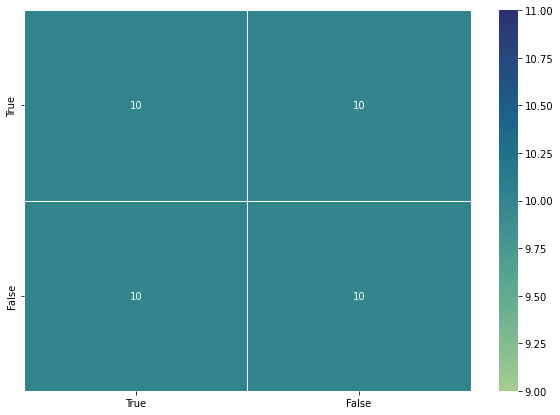

In [32]:
visualize_conf(10,10,10,10)

## Visualize class Diagramm

In [63]:
from plantuml import PlantUML
import matplotlib.image as mpimg

server = PlantUML(url='http://www.plantuml.com/plantuml/img/',
                          basic_auth={},
                          form_auth={}, http_opts={}, request_opts={})

In [64]:
current_dir = "/Users/vs21/Library/Mobile Documents/com~apple~CloudDocs/Work/RESEARCH/requirements_extraction/EVAL/PlantUML/"

In [65]:
def domain_model_gen(name, associations, aggregations, generalizations):

  # Output : Domänenmodell
    
    with open(current_dir + name + '.txt', 'w') as f:
        f.write('@startuml' + '\n')
        for association in associations:
            f.write(association[0] + ' -- ' + association[1] + '\n')
        for aggregation in aggregations:
            f.write(aggregation[0] + ' o-- ' + aggregation[1] + '\n')
        for extension in generalizations:
            f.write(extension[0] + ' <|-- ' + extension[1] + '\n')
        f.write('@enduml' + '\n')
    server.processes_file(current_dir + name + '.txt')
    
#     img = mpimg.imread(current_dir + name +'.png')
#     plt.figure(figsize = (5,10))
#     imgplot = plt.imshow(img, aspect='auto')

In [66]:
associations = [('Bestellung', 'Suchanfrage'), ('Qualifikation', 'Suchanfrage')]
aggregations = [['Consultant', 'Qualifikation'], ['Bestellung', 'Consultant']]
compositions = [['Kundenkonto', 'Bestellung']]
extensions = [["Bestellung", "Suchanfrage"]]

In [37]:
# domain_model_gen("test_plant_Uml", associations, aggregations, extensions)

# putting it all together

In [81]:
examples_dir = "/Users/vs21/Library/Mobile Documents/com~apple~CloudDocs/Work/RESEARCH/requirements_extraction/DATA/eng/"

def eval_classes():
    result_list = []
    examples = get_examples(examples_dir, test=False, test_folder="RentAConsult")
    for idx, example in enumerate(examples):
        print(f'Progress : {idx +1} / {len(examples)}')
        name, example_text, gt_labels, after_filter = example

        # get all nouns
        nlp_result_nouns = core_nlp(example_text)
        all_nouns = get_all_nouns(nlp_result_nouns)

        # apply rule based approach
        sentences = example[-1].split(".")
        rules_result = []
        for sentence in sentences:
            nlp_result = core_nlp(sentence)
            rules_result.append(rule_based_extraction(nlp_result))
        
        # return {"classes": all_classes, "methods": all_methods, "generalizations": all_generalization, "associations": all_association, "aggregations":all_aggregation}
        rules_result = post_processing(rules_result)
        
        # plantUML
        domain_model_gen(name, rules_result["associations"], rules_result["aggregations"], rules_result["generalizations"])
        

        # evaluate results
        # return [name, gt_labels, rule_results, tp, tn, fp, fn, accuracy, precision, all_nouns]
        result_list.append(eval_results(name, gt_labels, rules_result["classes"], all_nouns))

    
    return result_list
    



In [82]:
results = eval_classes()

Progress : 1 / 12
Progress : 2 / 12
Progress : 3 / 12
Progress : 4 / 12
Progress : 5 / 12
Progress : 6 / 12
Progress : 7 / 12
Progress : 8 / 12
Progress : 9 / 12
Progress : 10 / 12
Progress : 11 / 12
Progress : 12 / 12


### process results :
goes through the results and sums up tp, tn, fp, fn
and visualizes them

588


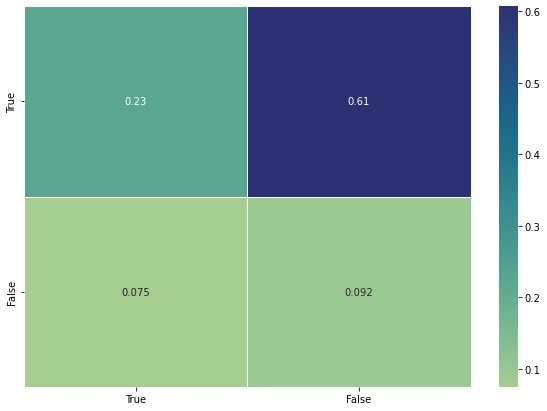

In [80]:
TP = TN = FN = FP = 0
for result in results:
    TP += len(result[3])
    TN += len(result[4])
    FP += len(result[5])
    FN += len(result[6])

total = TP + TN + FN + FP
print(total)
visualize_conf(TP/total, FP/total, FN/total, TN/total)